## NBA Shot Chart -- Season

Written by: Tim Chartier <br>
Adapted from: https://towardsdatascience.com/make-a-simple-nba-shot-chart-with-python-e5d70db45d0d


In [1]:
!pip install nba_api

from nba_api.stats.endpoints import shotchartdetail

In [2]:
# Import packages

import json
import requests
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

### Grab player ID number and team ID numbers

In [3]:
# Load teams file
teams = json.loads(requests.get('https://raw.githubusercontent.com/bttmly/nba/master/data/teams.json').text)
# Load players file
players = json.loads(requests.get('https://lifeislinear.davidson.edu/sports/player_dicts.json').text)

### ID helper functions

Create helper functions that take an input of a team name and a player’s name, and return their respective ID numbers. In both cases, if a player or team name cannot be found, the functions return -1


In [4]:
# Get team ID based on team name
def get_team_id(teamInput):
    for team in teams:
        if team['teamName'] == teamInput:
            return team['teamId']
    return -1
# Get player ID based on player name
def get_player_id(first, last):
    for player in players:
        if player['firstName'] == first and player['lastName'] == last:
            return player['playerId']
    return -1
# Get Name based on player id
def get_player_name(playerId):
    for player in players:
        if player['playerId']==playerId:
            return player['firstName'], player['lastName']
    return -1

### Collect shot data

documentation - https://github.com/swar/nba_api/blob/master/docs/nba_api/stats/endpoints/shotchartdetail.md

For made shots change to: context_measure_simple = 'PTS',
   else FGA

To get regular season data, change:             
<dd>season_type_all_star = 'Regular Season')


In [9]:
# Create JSON request
shot_json = shotchartdetail.ShotChartDetail(
            team_id = 0,
            player_id = get_player_id('Shaun', 'Livingston'),
            season_nullable='2018-19',
            context_measure_simple = 'FGA',
            season_type_all_star = 'Regular Season')

# Load JSON data into dictionary
shot_data = json.loads(shot_json.get_json())

### Convert dictionary to a dataframe and extra shots from a game on a given date.

In [10]:
shot_df = pd.concat(
    pd.DataFrame(shot, columns=shot_data['resultSets'][0]['headers'])
    for shot in [shot_data['resultSets'][0]['rowSet']]
)

print('There are %d shots by this player.\n' % len(shot_df))
shot_df.head(20)

There are 210 shots by this player.



,GRID_TYPE,GAME_ID,GAME_EVENT_ID,PLAYER_ID,PLAYER_NAME,TEAM_ID,TEAM_NAME,PERIOD,MINUTES_REMAINING,SECONDS_REMAINING,...,SHOT_ZONE_AREA,SHOT_ZONE_RANGE,SHOT_DISTANCE,LOC_X,LOC_Y,SHOT_ATTEMPTED_FLAG,SHOT_MADE_FLAG,GAME_DATE,HTM,VTM
0,Shot Chart Detail,0021800002,297,2733,Shaun Livingston,1610612744,Golden State Warriors,2,5,40,...,Right Side(R),8-16 ft.,9,95,8,1,0,20181016,GSW,OKC
1,Shot Chart Detail,0021800002,525,2733,Shaun Livingston,1610612744,Golden State Warriors,3,2,6,...,Center(C),Less Than 8 ft.,0,0,-6,1,1,20181016,GSW,OKC
2,Shot Chart Detail,0021800002,545,2733,Shaun Livingston,1610612744,Golden State Warriors,3,0,49,...,Center(C),8-16 ft.,10,20,105,1,0,20181016,GSW,OKC
3,Shot Chart Detail,0021800002,555,2733,Shaun Livingston,1610612744,Golden State Warriors,3,0,1,...,Center(C),Less Than 8 ft.,3,-18,26,1,1,20181016,GSW,OKC
4,Shot Chart Detail,0021800002,595,2733,Shaun Livingston,1610612744,Golden State Warriors,4,9,58,...,Center(C),8-16 ft.,10,-22,106,1,1,20181016,GSW,OKC
5,Shot Chart Detail,0021800024,170,2733,Shaun Livingston,1610612744,Golden State Warriors,1,0,44,...,Center(C),8-16 ft.,14,70,126,1,1,20181019,UTA,GSW
6,Shot Chart Detail,0021800024,213,2733,Shaun Livingston,1610612744,Golden State Warriors,2,10,9,...,Center(C),Less Than 8 ft.,6,-22,63,1,1,20181019,UTA,GSW
7,Shot Chart Detail,0021800024,535,2733,Shaun Livingston,1610612744,Golden State Warriors,4,9,49,...,Center(C),8-16 ft.,12,22,122,1,0,20181019,UTA,GSW
8,Shot Chart Detail,0021800024,558,2733,Shaun Livingston,1610612744,Golden State Warriors,4,8,40,...,Center(C),Less Than 8 ft.,2,18,23,1,1,20181019,UTA,GSW
9,Shot Chart Detail,0021800062,172,2733,Shaun Livingston,1610612744,Golden State Warriors,1,0,35,...,Center(C),Less Than 8 ft.,0,0,-6,1,0,20181024,GSW,WAS


### Pull the made and missed shots.

In relation to our shot chart in this program, we need to flip x coordinate about the x-axis.

In [11]:
shot_df.loc[:]['LOC_X'] = -shot_df.loc[:]['LOC_X']

missedShots = shot_df.loc[shot_df['SHOT_MADE_FLAG'] == 0]
madeShots = shot_df.loc[shot_df['SHOT_MADE_FLAG'] == 1]

### Create function to draw the court

In [8]:
# Function to draw basketball court
def create_court(ax, color):
    # Short corner 3PT lines
    ax.plot([-220, -220], [0, 140], linewidth=2, color=color)
    ax.plot([220, 220], [0, 140], linewidth=2, color=color)

    # 3PT Arc
    ax.add_artist(mpl.patches.Arc((0, 140), 440, 315, theta1=0, theta2=180, facecolor='none', edgecolor=color, lw=2))

    # Lane and Key
    ax.plot([-80, -80], [0, 190], linewidth=2, color=color)
    ax.plot([80, 80], [0, 190], linewidth=2, color=color)
    ax.plot([-60, -60], [0, 190], linewidth=2, color=color)
    ax.plot([60, 60], [0, 190], linewidth=2, color=color)
    ax.plot([-80, 80], [190, 190], linewidth=2, color=color)
    ax.add_artist(mpl.patches.Circle((0, 190), 60, facecolor='none', edgecolor=color, lw=2))

    # Rim
    ax.add_artist(mpl.patches.Circle((0, 60), 15, facecolor='none', edgecolor=color, lw=2))

    # Backboard
    ax.plot([-30, 30], [40, 40], linewidth=2, color=color)

    # Remove ticks
    ax.set_xticks([])
    ax.set_yticks([])

    # Set axis limits
    ax.set_xlim(-250, 250)
    ax.set_ylim(0, 470)

### Create short chart

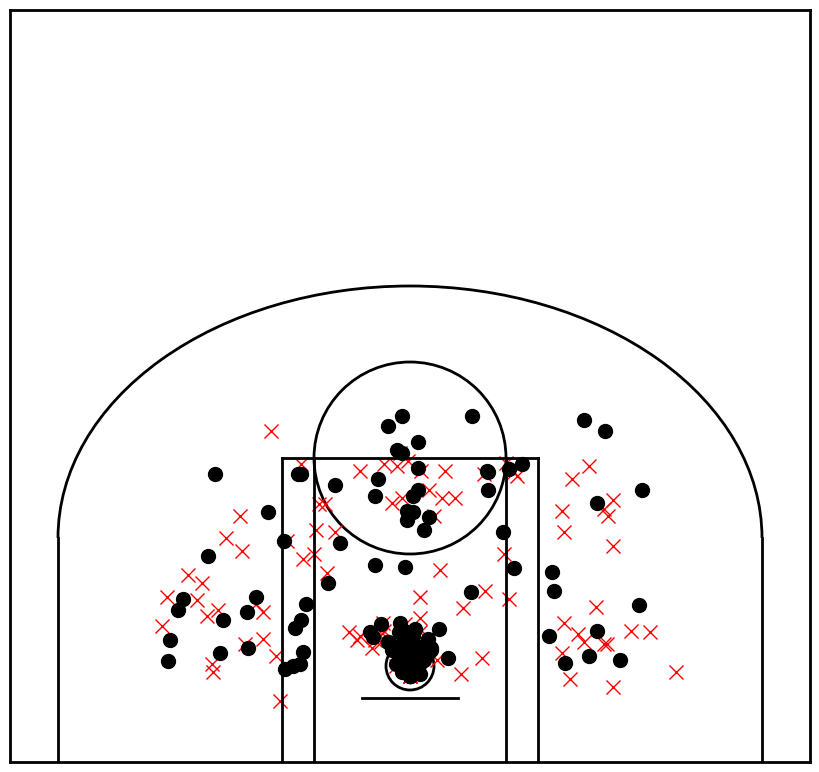

In [9]:
# General plot parameters
#mpl.rcParams['font.family'] = 'Avenir'
mpl.rcParams['font.size'] = 18
mpl.rcParams['axes.linewidth'] = 2

# Draw basketball court
#fig = plt.figure(figsize=(4, 3.76))
fig = plt.figure(figsize=(8, 7.52))
ax = fig.add_axes([0, 0, 1, 1])

# Plot shotchart
plt.plot(missedShots['LOC_X'], missedShots['LOC_Y'] + 60,'rx',markersize=10)
plt.plot(madeShots['LOC_X'], madeShots['LOC_Y'] + 60,'ko',markersize=10)

ax = create_court(ax, 'black')
# Annotate player name and season
#fig.text(0, 1.05, 'Stephen Curry\n2021-22 Playoffs Season', ha='left', va='baseline')

#plt.savefig('curryShotchartPlayoffs.png',dpi=400,pad_inches=0,bbox_inches='tight')

plt.show()

### Save the data to a CSV file for use in spreadsheets

In [ ]:
#curry_data.to_csv('curryShots.csv')

### Find the player's hot zones.

In [14]:
def shooting_perc(group):
    made = group['SHOT_MADE_FLAG'].sum()
    attempted = group['SHOT_ATTEMPTED_FLAG'].sum()
    return round((made / attempted) * 100, 2)

shot_df['ZONE_SPECIFIC'] = shot_df['SHOT_ZONE_AREA'] + ' ' + shot_df['SHOT_ZONE_RANGE']
zones = shot_df.groupby('ZONE_SPECIFIC')
shooting_zones = zones.apply(shooting_perc)

shooting_zones.head(14)

0
2

1
1

23
44

57
91

1
2

13
35

3
5

0
1

11
29



ZONE_SPECIFIC
Back Court(BC) Back Court Shot       0.00
Center(C) 16-24 ft.                100.00
Center(C) 8-16 ft.                  52.27
Center(C) Less Than 8 ft.           62.64
Left Side Center(LC) 16-24 ft.      50.00
Left Side(L) 8-16 ft.               37.14
Right Side Center(RC) 16-24 ft.     60.00
Right Side(R) 16-24 ft.              0.00
Right Side(R) 8-16 ft.              37.93
dtype: float64

### Find Heat Checks

In [17]:
def find_hh(data, player_id, hh_thresh, shot_type=-1):
    # Data - the data frame to filter
    # player_id - the player we are investigating
    # hh_thresh - how many mae shots in a row to qualify for a "hot hand"

    if shot_type == 2:
        data = data[data["SHOT_TYPE"] == "2PT Field Goal"]
    elif shot_type == 3:
        data = data[data["SHOT_TYPE"] == "3PT Field Goal"]

    
    player_data = data[data["PLAYER_ID"] == player_id]
    
    made_count = 0
    for index, row in player_data.iterrows():
        if row["SHOT_MADE_FLAG"] == 1:
            made_count += 1
        else:
            made_count = 0

        if made_count < hh_thresh:
            player_data.at[index, 'HOT_HAND'] = 0
        else:
            player_data.at[index, 'HOT_HAND'] = 1

    return player_data

def heat_check(data):
    # A function to find the misses following a hot hand
    
    # index - 1 was throwing errors, so to get the previous hot hand shots we will use shift
    temp = data
    temp['p_hh'] = data["HOT_HAND"].shift(1).fillna(0)
    data['HEAT_CHECK'] = ((data['SHOT_MADE_FLAG'] == 0) & (temp['p_hh'] == 1)).astype(int)
    
    return data

In [18]:
shot_df = find_hh(shot_df, get_player_id("Jordan", "Poole"), 3)
shot_df = heat_check(shot_df)

heat_check_zones = shot_df.groupby('ZONE_SPECIFIC').sum()['HEAT_CHECK']
heat_check_zones.head(14)

ZONE_SPECIFIC
Back Court(BC) Back Court Shot      1
Center(C) 16-24 ft.                 1
Center(C) 24+ ft.                   7
Center(C) 8-16 ft.                  0
Center(C) Less Than 8 ft.           7
Left Side Center(LC) 16-24 ft.      2
Left Side Center(LC) 24+ ft.       14
Left Side(L) 16-24 ft.              0
Left Side(L) 24+ ft.                3
Left Side(L) 8-16 ft.               0
Right Side Center(RC) 16-24 ft.     3
Right Side Center(RC) 24+ ft.      14
Right Side(R) 16-24 ft.             0
Right Side(R) 24+ ft.               2
Name: HEAT_CHECK, dtype: int64

In [19]:
sz = pd.DataFrame(shooting_zones)
hcz = pd.DataFrame(heat_check_zones)

analysis = pd.merge(sz, hcz, on='ZONE_SPECIFIC')
analysis.head(14)

,0,HEAT_CHECK
ZONE_SPECIFIC,,
Back Court(BC) Back Court Shot,0.00,1
Center(C) 16-24 ft.,34.62,1
Center(C) 24+ ft.,38.10,7
Center(C) 8-16 ft.,49.06,0
Center(C) Less Than 8 ft.,61.02,7
Left Side Center(LC) 16-24 ft.,48.28,2
Left Side Center(LC) 24+ ft.,31.71,14
Left Side(L) 16-24 ft.,0.00,0
Left Side(L) 24+ ft.,44.19,3


After you make two or three in a row, do you start to shoot from further out?

Do you start to shoot more layups after you go on a hot hand?

We can get the score of the game from another NBA api. We could probably also get the shot clock, and then we can see how to shot clock affects a player's shooting percentage as well.

Calculate the percentage of shots taken in each zone out of the total shots taken.

shot location when they're behind or tied
shot location when they're ahead or tied
what's your average shot distance? after a hot hand

just look at the top 10 3pt shooters over the past 5 years


In [16]:
from nba_api.stats.endpoints import commonteamroster
from nba_api.stats.static import teams

nba_teams = teams.get_teams()
team_rosters = pd.DataFrame()

SEASON = 2023 # Change to your desired season

for team in nba_teams:
    team_id = team['id']
    team_roster = commonteamroster.CommonTeamRoster(team_id = team_id, season=SEASON)
    df = team_roster.get_data_frames()[0]
    df['TEAM'] = team['full_name']
    team_rosters = pd.concat([team_rosters, df], ignore_index=True)

team_rosters.head()


,TeamID,SEASON,LeagueID,PLAYER,NICKNAME,PLAYER_SLUG,NUM,POSITION,HEIGHT,WEIGHT,BIRTH_DATE,AGE,EXP,SCHOOL,PLAYER_ID,HOW_ACQUIRED,TEAM
0,1610612737,2023,00,Jalen Johnson,Jalen,jalen-johnson,1,F,6-8,219,"DEC 18, 2001",22.0,2,Duke,1630552,#20 Pick in 2021 Draft,Atlanta Hawks
1,1610612737,2023,00,Trent Forrest,Trent,trent-forrest,2,G,6-4,210,"JUN 12, 1998",25.0,3,Florida State,1630235,Signed on 08/08/22,Atlanta Hawks
2,1610612737,2023,00,Seth Lundy,Seth,seth-lundy,3,G-F,6-4,220,"APR 02, 2000",24.0,R,Penn State,1641754,#46 Pick in 2023 Draft,Atlanta Hawks
3,1610612737,2023,00,Kobe Bufkin,Kobe,kobe-bufkin,4,G,6-5,195,"SEP 21, 2003",20.0,R,Michigan,1641723,#15 Pick in 2023 Draft,Atlanta Hawks
4,1610612737,2023,00,Dejounte Murray,Dejounte,dejounte-murray,5,G,6-5,180,"SEP 19, 1996",27.0,6,Washington,1627749,Traded from SAS on 06/30/22,Atlanta Hawks
